# Exploring Patterns and Predictors in Patient Data to Uncover the Secrets of Sepsis Occurance. 

# Intro

## General

In the realm of healthcare, understanding the complex dynamics behind the occurrence of life-threatening conditions is of paramount importance. Sepsis, a potentially fatal condition resulting from the body's extreme response to an infection, remains a major challenge for healthcare providers worldwide. Unraveling the secrets of sepsis occurrence can lead to improved early detection, timely interventions, and ultimately, better patient outcomes.

This project aims to delve into the vast pool of patient data, harnessing the power of data analysis and machine learning, to explore patterns and predictors associated with sepsis occurrence. By leveraging advanced computational techniques and drawing insights from comprehensive patient records, this research endeavor seeks to uncover hidden correlations, risk factors, and potential early warning signs that can facilitate earlier diagnosis and intervention.


## Outlier Analysis

# Setup

## Importation

Here is the section to import all the packages/libraries that will be used through this notebook.

In [1]:
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import skew

#Data Splitting
from sklearn.model_selection import train_test_split, GridSearchCV
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB


#Evaluation metrics
from sklearn.metrics import f1_score,roc_curve, auc,roc_auc_score
#saving model                            
import pickle

import warnings
warnings.filterwarnings('ignore')

# Data Loading

Here is the section to load the datasets (train, eval, test) and the additional files

In [2]:
urls = {
    "train": "https://raw.githubusercontent.com/aliduabubakari/Sepsis-Classification-with-FastAPI/main/Data/Paitients_Files_Train.csv",
    "test": "https://raw.githubusercontent.com/aliduabubakari/Sepsis-Classification-with-FastAPI/main/Data/Paitients_Files_Test.csv"
}

train = pd.read_csv(urls["train"])
test = pd.read_csv(urls["test"])

# Print the first few rows of the DataFrame
print(train.head())


          ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive


- ID: Unique number to represent patient ID

- PRG: Plasma glucose

- PL: Blood Work Result-1 (mu U/ml)

- PR: Blood Pressure (mm Hg)

- SK: Blood Work Result-2 (mm)

- TS: Blood Work Result-3 (mu U/ml)

- M11: Body mass index (weight in kg/(height in m)^2

- BD2: Blood Work Result-4 (mu U/ml)

- Age	: patients age (years)

- Insurance: If a patient holds a valid insurance card

- Sepssis; Positive: if a patient in ICU will develop a sepsis , and Negative: otherwise

In [3]:

# Print the first few rows of the DataFrame
print(test.head())

          ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance
0  ICU200609    1  109  38  18  120  23.1  0.407   26          1
1  ICU200610    1  108  88  19    0  27.1  0.400   24          1
2  ICU200611    6   96   0   0    0  23.7  0.190   28          1
3  ICU200612    1  124  74  36    0  27.8  0.100   30          1
4  ICU200613    7  150  78  29  126  35.2  0.692   54          0


# Feature Processing & Engineering
Here is the section to **clean**, **process** the dataset and **create new features**.

### Data Imbalance Check

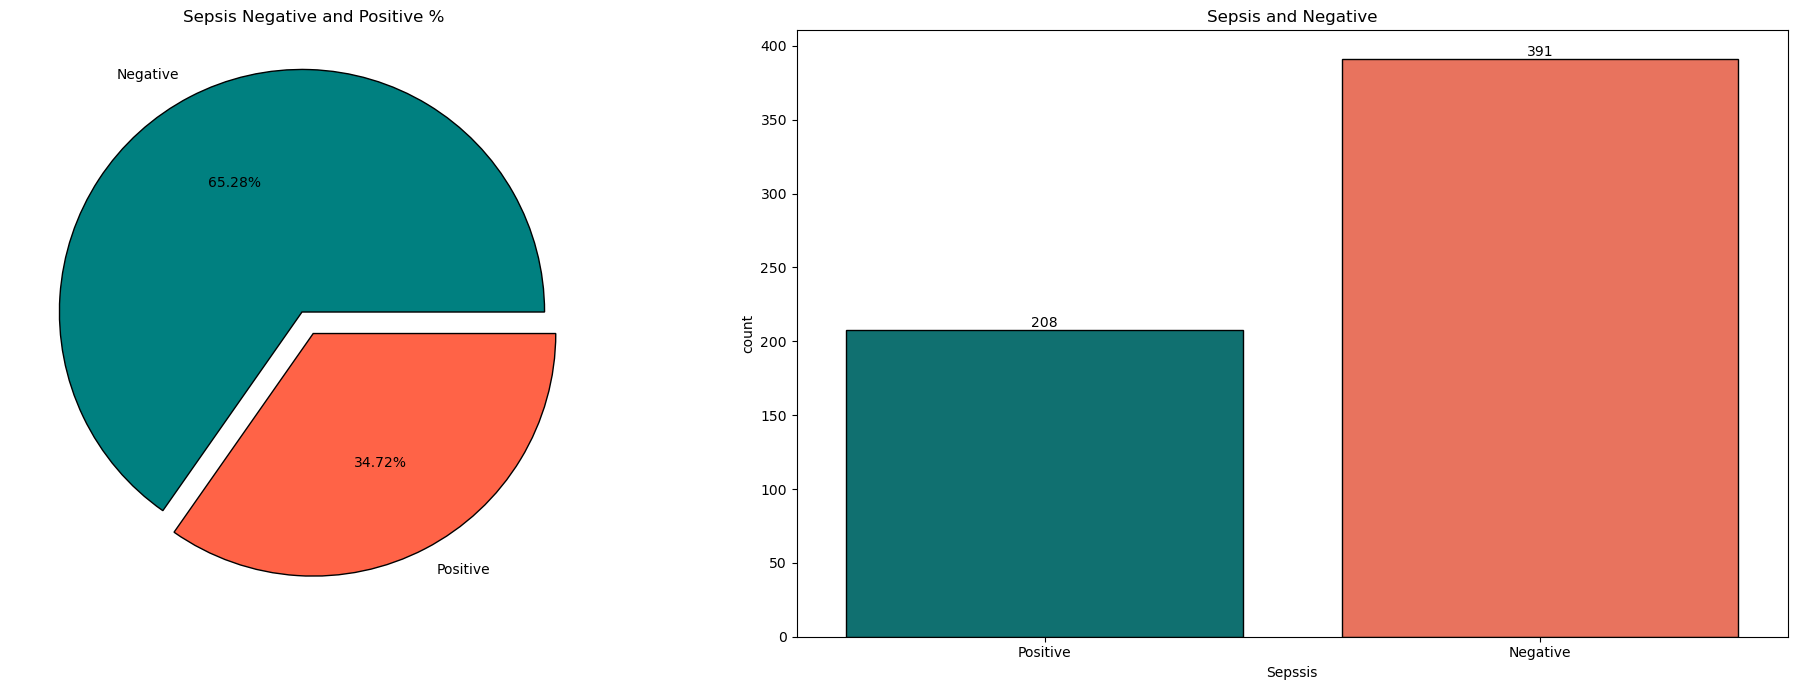

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for the plots
palette = ['#008080', '#FF6347', '#E50000', '#D2691E']

# Calculate the percentage of positive and negative values
sepsis_counts = train['Sepssis'].value_counts()
pie_values = [sepsis_counts[0] / sepsis_counts.sum() * 100, sepsis_counts[1] / sepsis_counts.sum() * 100]

# Create the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Plot the pie chart on the first subplot
axes[0].pie(pie_values, labels=['Negative', 'Positive'], autopct='%1.2f%%', explode=(0.1, 0),
            colors=palette[:2], wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[0].set_title('Sepsis Negative and Positive %')

# Plot the countplot on the second subplot
sns.countplot(data=train, x='Sepssis', palette=palette[:2], edgecolor='black', ax=axes[1])
axes[1].set_xticklabels(['Positive', 'Negative'])
axes[1].set_title('Sepsis and Negative')

# Add labels to the countplot bars
for container in axes[1].containers:
    axes[1].bar_label(container)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


As can be observed the dataset is imbalanced and therefore particular attention needs to be paid in the selection of ML models

## Drop Duplicates

In [5]:
def check_duplicate_rows(data):
    duplicate_rows = data.duplicated()
    num_duplicates = duplicate_rows.sum()
    print("Number of duplicate rows:", num_duplicates)

In [6]:
# Check duplicate rows in train data
check_duplicate_rows(train)

# Check duplicate rows in test data
check_duplicate_rows(test)


Number of duplicate rows: 0
Number of duplicate rows: 0


## Impute Missing Values

In [7]:
def check_missing_values(data):
    missing_values = data.isna().sum()
    print("Missing values:\n", missing_values)

In [8]:
# Check missing values in train data
check_missing_values(train)

# Check missing values in test data
check_missing_values(test)


Missing values:
 ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64
Missing values:
 ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
dtype: int64


## Features Encoding

In [9]:
from sklearn.preprocessing import LabelEncoder

def encode_target_variable(data, target_variable):
    # Encode the target variable using LabelEncoder
    label_encoder = LabelEncoder()
    encoded_target = label_encoder.fit_transform(data[target_variable])
    target_encoded = pd.DataFrame(encoded_target, columns=[target_variable])

    # Combine the features and the encoded target variable
    data_encoded = pd.concat([data.iloc[:, :-1], target_encoded], axis=1)
    data_encoded.drop('ID', axis=1, inplace=True)

    return data_encoded



In [10]:
# Encode target variable in train data
train_encoded = encode_target_variable(train, 'Sepssis')

# Print the encoded train data
print(train_encoded.head())

   PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance  Sepssis
0    6  148  72  35    0  33.6  0.627   50          0        1
1    1   85  66  29    0  26.6  0.351   31          0        0
2    8  183  64   0    0  23.3  0.672   32          1        1
3    1   89  66  23   94  28.1  0.167   21          1        0
4    0  137  40  35  168  43.1  2.288   33          1        1


## Dataset Splitting

In [11]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size, random_state=42, stratify=None):
    # Split the data into train and validation sets
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=stratify)

    return X_train, X_eval, y_train, y_eval


In [32]:
X_train.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
161,7,102,74,40,105,37.2,0.204,45,1
236,7,181,84,21,192,35.9,0.586,51,0
497,2,81,72,15,76,30.1,0.547,25,1
40,3,180,64,25,70,34.0,0.271,26,0
372,0,84,64,22,66,35.8,0.545,21,1


In [12]:
# Split the data into train and validation sets for both X and y
X_train, X_eval, y_train, y_eval = split_data(train_encoded.iloc[:, :-1], train_encoded.iloc[:, -1:], test_size=0.2, random_state=42, stratify=train_encoded.iloc[:, -1:])

# Print the shapes of the train and validation sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_eval shape:", X_eval.shape)
print("y_eval shape:", y_eval.shape)

X_train shape: (479, 9)
y_train shape: (479, 1)
X_eval shape: (120, 9)
y_eval shape: (120, 1)


In [17]:
X_train.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
161,7,102,74,40,105,37.2,0.204,45,1
236,7,181,84,21,192,35.9,0.586,51,0
497,2,81,72,15,76,30.1,0.547,25,1
40,3,180,64,25,70,34.0,0.271,26,0
372,0,84,64,22,66,35.8,0.545,21,1


In [22]:
import pandas as pd
import numpy as np
from scipy.stats import skew

def cap_floor_outliers(data):
    """
    Apply data capping and flooring to outliers in the given data, considering skewness.

    Args:
        data (array-like or DataFrame): Input data array or DataFrame.

    Returns:
        array-like or DataFrame: Data with outliers capped and floored.
    """
    capped_data = data.copy()

    if isinstance(data, pd.DataFrame):
        numerical_cols = data.select_dtypes(include=np.number).columns
        for col in numerical_cols:
            col_data = data[col]
            skewness = skew(col_data)
            q1 = np.percentile(col_data, 25)
            q3 = np.percentile(col_data, 75)
            iqr = q3 - q1
            upper_threshold = q3 + 1.5 * iqr
            lower_threshold = q1 - 1.5 * iqr

            # Cap outliers above the upper threshold
            capped_data.loc[data[col] > upper_threshold, col] = upper_threshold

            # Floor outliers below the lower threshold
            capped_data.loc[data[col] < lower_threshold, col] = lower_threshold

    return capped_data

# Apply outlier trimming to the train and evaluation sets
X_train_capped = cap_floor_outliers(X_train)
y_train_capped = cap_floor_outliers(y_train)
X_eval_capped = cap_floor_outliers(X_eval)
y_eval_capped = cap_floor_outliers(y_eval)

# Print the shapes of the trimmed sets
print("X_train_capped shape:", X_train_capped.shape)
print("y_train_capped shape:", y_train_capped.shape)
print("X_eval_capped shape:", X_eval_capped.shape)
print("y_eval_capped shape:", y_eval_capped.shape)


X_train_capped shape: (479, 9)
y_train_capped shape: (479, 1)
X_eval_capped shape: (120, 9)
y_eval_capped shape: (120, 1)


In [23]:
X_train_capped.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
161,7.0,102,74,40,105,37.2,0.204,45,1.0
236,7.0,181,84,21,192,35.9,0.586,51,0.0
497,2.0,81,72,15,76,30.1,0.547,25,1.0
40,3.0,180,64,25,70,34.0,0.271,26,0.0
372,0.0,84,64,22,66,35.8,0.545,21,1.0


In [121]:
def iqr_trimming(train, cols, factor):
    """
    Apply IQR trimming to the given data.

    Args:
        train (DataFrame): Input training data.
        cols (list): List of columns to trim.
        factor (float): Trimming factor.

    Returns:
        DataFrame: Trimmed training data.
    """
    trimmed_train = train.copy()

    for col in cols:
        q1 = trimmed_train[col].quantile(0.25)
        q3 = trimmed_train[col].quantile(0.75)
        iqr = q3 - q1

        upper_whisker = q3 + (factor * iqr)
        lower_whisker = q1 - (factor * iqr)

        outliers_mask = (trimmed_train[col] > upper_whisker) | (trimmed_train[col] < lower_whisker)
        trimmed_train = trimmed_train[~outliers_mask]

    return trimmed_train


In [160]:
# Apply IQR trimming to the train and evaluation sets
X_train_trimmed = iqr_trimming(X_train, X_train.columns, factor=1.5)
y_train_trimmed = iqr_trimming(y_train, y_train.columns, factor=1.5)
#y_train_trimmed = y_train_trimmed.loc[X_train_trimmed.index]
X_eval_trimmed = iqr_trimming(X_eval, X_eval.columns, factor=1.5)
y_eval_trimmed = iqr_trimming(y_eval, y_eval.columns, factor=1.5)


# Print the shapes of the trimmed sets
print("X_train_trimmed shape:", X_train_trimmed.shape)
print("y_train_trimmed shape:", y_train_trimmed.shape)
print("X_eval_trimmed shape:", X_eval_trimmed.shape)
print("y_eval_trimmed shape:", y_eval_trimmed.shape)


X_train_trimmed shape: (401, 9)
y_train_trimmed shape: (479, 1)
X_eval_trimmed shape: (87, 9)
y_eval_trimmed shape: (120, 1)


In [140]:
X_train_trimmed.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
161,7,102,74,40,105,37.2,0.204,45,1
236,7,181,84,21,192,35.9,0.586,51,0
497,2,81,72,15,76,30.1,0.547,25,1
40,3,180,64,25,70,34.0,0.271,26,0
372,0,84,64,22,66,35.8,0.545,21,1


## Imputting Missing Values

In [142]:
# Creating imputer variables
numerical_imputer = SimpleImputer(strategy = "mean")

numerical_imputer.fit(X_train)

X_train_imputed = numerical_imputer.transform(X_train)
X_eval_imputed = numerical_imputer.transform(X_eval)

X_train_capped_imputed = numerical_imputer.transform(X_train_capped)
X_eval_capped_imputed = numerical_imputer.transform(X_eval_capped)

X_train_trimmed_imputed = numerical_imputer.transform(X_train_trimmed)
X_eval_trimmed_imputed = numerical_imputer.transform(X_eval_trimmed)

In [143]:
X_train_trimmed.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
161,7,102,74,40,105,37.2,0.204,45,1
236,7,181,84,21,192,35.9,0.586,51,0
497,2,81,72,15,76,30.1,0.547,25,1
40,3,180,64,25,70,34.0,0.271,26,0
372,0,84,64,22,66,35.8,0.545,21,1


## Features Scaling

In [144]:
scaler = StandardScaler()
scaler.fit(X_train_imputed)

columns = ['PRG','PL','PR','SK','TS','M11','BD2','Age','Insurance']

def scale_data(data, scaler, columns):
    scaled_data = scaler.transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=columns)
    return scaled_df


In [145]:
# Scale the datasets using the scale_data function
X_train_scaled = scale_data(X_train_imputed, scaler, columns)
X_eval_scaled = scale_data(X_eval_imputed, scaler, columns)
X_train_capped_scaled = scale_data(X_train_capped_imputed, scaler, columns)
X_eval_capped_scaled = scale_data(X_eval_capped_imputed, scaler, columns)
X_train_trimmed_scaled = scale_data(X_train_trimmed_imputed, scaler, columns)
X_eval_trimmed_scaled = scale_data(X_eval_trimmed_imputed, scaler, columns)


In [146]:
X_eval_trimmed_scaled.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,-0.263656,-0.978634,-0.539557,-0.606739,-0.207346,-0.939477,-0.645614,-0.975877,0.678503
1,-1.163592,-0.572966,-0.331551,-1.302627,-0.722247,-1.324452,-0.449678,-0.719274,0.678503
2,-0.563634,0.831272,0.396471,0.911561,1.127582,0.839374,-0.469556,-0.377137,0.678503
3,-1.163592,-0.167297,0.604477,0.848299,1.995285,1.635875,-0.929578,-0.548206,0.678503
4,-1.163592,0.363193,1.020490,-1.302627,-0.722247,-0.036776,0.706058,-0.120534,0.678503


In [147]:
print("X_train_trimmed_scaled shape:", X_train_trimmed_scaled.shape)
print("y_train_trimmed shape:", y_train_trimmed.shape)
print("X_eval_trimmed_scaled shape:", X_eval_trimmed_scaled.shape)
print("y_eval_trimmed shape:", y_eval_trimmed.shape)


X_train_trimmed_scaled shape: (401, 9)
y_train_trimmed shape: (401, 1)
X_eval_trimmed_scaled shape: (87, 9)
y_eval_trimmed shape: (120, 1)


# Machine Learning Modeling 
Here is the section to **build**, **train**, **evaluate** and **compare** the models to each others.

### Simple Model #001 - Linear regression

Please, keep the following structure to try all the model you want.

In [ ]:
#fit logistic regression model on train data
Lrmodel = LogisticRegression()
Lrmodel.fit(X_train_df, y_train)

#make predictions on validation set
Lrpreds = Lrmodel.predict(X_eval_df)

f1Score =f1_score(y_eval, Lrpreds)
f1Score

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

def logistic_regression_model(X_train, y_train, X_eval, y_eval):
    # Fit logistic regression model
    lr_model = LogisticRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    lr_preds = lr_model.predict(X_eval)

    # Calculate F1 score
    lr_f1_score = f1_score(y_eval, lr_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, lr_preds)

    # Calculate AUC score
    lr_auc_score = roc_auc_score(y_eval, lr_preds)

    return lr_model, lr_preds, lr_f1_score, fpr, tpr, thresholds, lr_auc_score


In [149]:
# Run logistic regression model for each dataset
lr_model, lr_preds, lr_f1_score, fpr, tpr, thresholds, lr_auc_score = logistic_regression_model(X_train_scaled, y_train, X_eval_scaled, y_eval)


In [150]:
print("F1 Score:", lr_f1_score)
print("AUC Score:", lr_auc_score)


F1 Score: 0.6265060240963854
AUC Score: 0.7133699633699634


In [151]:
lr_capped_model, lr_capped_preds, lr_capped_f1_score, capped_fpr, capped_tpr, capped_thresholds, lr_capped_auc_score = logistic_regression_model(X_train_capped_scaled, y_train_capped, X_eval_capped_scaled, y_eval_capped)


In [152]:
print("F1 Score:", lr_capped_f1_score)
print("AUC Score:", lr_capped_auc_score)

F1 Score: 0.6265060240963854
AUC Score: 0.7133699633699634


In [153]:
print("X_train_trimmed_scaled shape:", X_train_trimmed_scaled.shape)
print("y_train_trimmed shape:", y_train_trimmed.shape)
print("X_eval_trimmed_scaled shape:", X_eval_trimmed_scaled.shape)
print("y_eval_trimmed shape:", y_eval_trimmed.shape)


X_train_trimmed_scaled shape: (401, 9)
y_train_trimmed shape: (401, 1)
X_eval_trimmed_scaled shape: (87, 9)
y_eval_trimmed shape: (120, 1)


In [154]:
# Run logistic regression model for each dataset
lr_trimmed_model, lr_trimmed_preds, lr_trimmed_f1_score, trimmed_fpr, trimmed_tpr, trimmed_thresholds, lr_trimmed_auc_score = logistic_regression_model(X_train_trimmed_scaled, y_train_trimmed, X_eval_trimmed_scaled, y_eval_trimmed)

# Print the F1 score and AUC score
print("F1 Score:", lr_trimmed_f1_score)
print("AUC Score:", lr_trimmed_auc_score)


ValueError: Found input variables with inconsistent numbers of samples: [120, 87]

In [104]:
print("F1 Score:", lr_trimmed_f1_score)
print("AUC Score:", lr_trimmed_auc_score)

F1 Score: 0.6265060240963854
AUC Score: 0.7133699633699634


In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


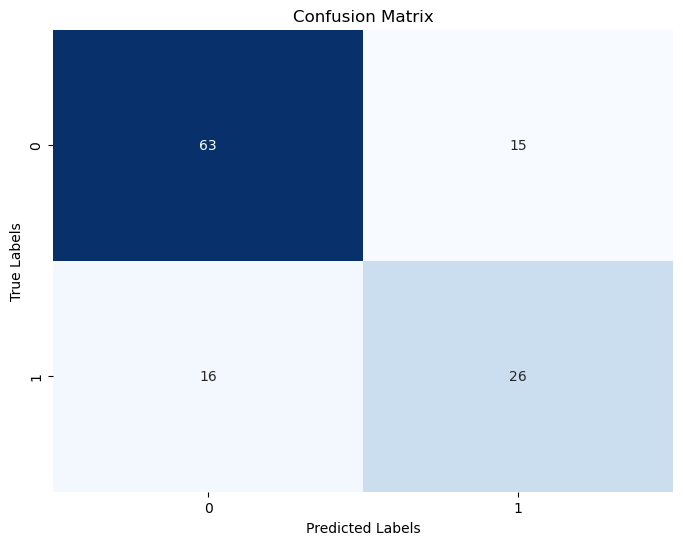

In [106]:
# Plot confusion matrix for each dataset
plot_confusion_matrix(y_eval, lr_preds)

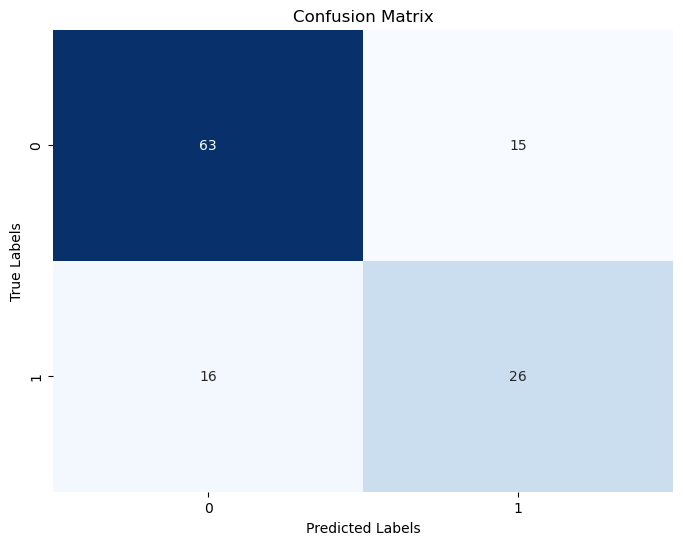

In [61]:
plot_confusion_matrix(y_eval_capped, lr_capped_preds)

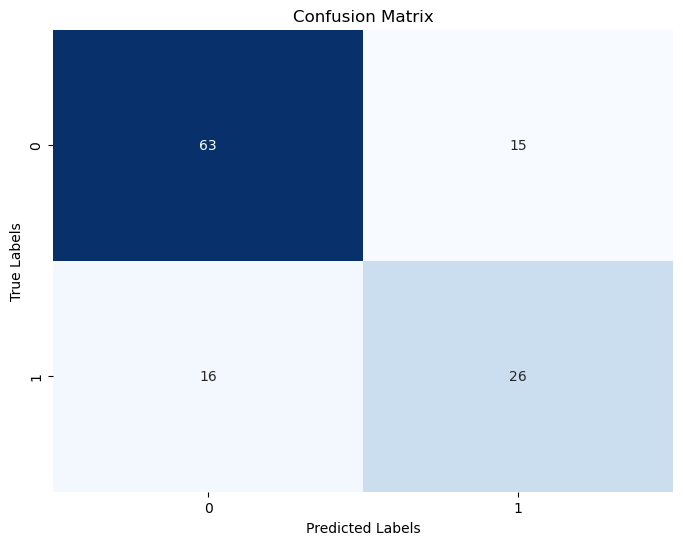

In [62]:
plot_confusion_matrix(y_eval_trimmed, lr_trimmed_preds)

##### Checking for overfitting 

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def calculate_f1_score(model, X, y):
    predictions = model.predict(X)
    f1 = f1_score(y, predictions)
    return f1


In [53]:
# Calculate F1 score for each dataset
Lr_train_f1_score = calculate_f1_score(lr_model, X_train_scaled, y_train.values.ravel())
Lr_eval_f1_score = calculate_f1_score(lr_model, X_eval_scaled, y_eval.values.ravel())

# Print the F1 scores
print("F1 Score on Training Set:", Lr_train_f1_score)
print("F1 Score on Evaluation Set:", Lr_eval_f1_score)


F1 Score on Training Set: 0.6486486486486487
F1 Score on Evaluation Set: 0.6265060240963854


In [54]:
Lr_train_f1_score_capped = calculate_f1_score(lr_capped_model, X_train_capped_scaled, y_train_capped.values.ravel())
Lr_eval_f1_score_capped = calculate_f1_score(lr_capped_model, X_eval_capped_scaled, y_eval_capped.values.ravel())

# Print the F1 scores
print("F1 Score on Training Set:", Lr_train_f1_score_capped)
print("F1 Score on Evaluation Set:", Lr_eval_f1_score_capped)

F1 Score on Training Set: 0.6486486486486487
F1 Score on Evaluation Set: 0.6265060240963854


In [55]:
Lr_train_f1_score_trimmed = calculate_f1_score(lr_trimmed_model, X_train_trimmed_scaled, y_train_trimmed.values.ravel())
Lr_eval_f1_score_trimmed = calculate_f1_score(lr_trimmed_model, X_eval_trimmed_scaled, y_eval_trimmed.values.ravel())

# Print the F1 scores
print("F1 Score on Training Set:", Lr_train_f1_score_trimmed)
print("F1 Score on Evaluation Set:", Lr_eval_f1_score_trimmed)

F1 Score on Training Set: 0.6486486486486487
F1 Score on Evaluation Set: 0.6265060240963854


In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import numpy as np

def perform_cross_validation(model, X, y, cv=5, scoring='f1'):
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)

    # Calculate the average score
    avg_score = np.mean(cv_scores)

    return cv_scores, avg_score

In [57]:
# Call the function with your logistic regression model and train data
cv_scores, avg_f1_score = perform_cross_validation(lr_model, X_train_scaled, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)


Cross-Validation Scores: [0.6557377  0.64615385 0.65384615 0.55555556 0.70967742]
Average F1 Score: 0.6441941359656853


In [58]:
# Call the function with your logistic regression model and train data
cv_scores, avg_f1_score = perform_cross_validation(lr_capped_model, X_train_scaled, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)


Cross-Validation Scores: [0.6557377  0.64615385 0.65384615 0.55555556 0.70967742]
Average F1 Score: 0.6441941359656853


In [59]:
# Call the function with your logistic regression model and train data
cv_scores, avg_f1_score = perform_cross_validation(lr_trimmed_model, X_train_scaled, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)


Cross-Validation Scores: [0.6557377  0.64615385 0.65384615 0.55555556 0.70967742]
Average F1 Score: 0.6441941359656853


### Simple Model #002 - Decision trees

In [107]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score

def evaluate_decision_tree(X_train, y_train, X_eval, y_eval):
    # Create and fit the decision tree classifier model
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    dt_pred = dt_model.predict(X_eval)

    # Calculate the F1 score
    dt_f1_score = f1_score(y_eval, dt_pred)

    # Calculate the false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, dt_pred)

    # Calculate the AUC (Area Under the Curve)
    dt_auc_score = roc_auc_score(y_eval, dt_pred)
    return dt_model, dt_pred, dt_f1_score, dt_auc_score



In [108]:
# Call the function with your train and evaluation data
dt_model, dt_pred, dt_f1_score, dt_auc_score = evaluate_decision_tree(X_train_scaled, y_train, X_eval_scaled, y_eval)

print("F1 Score:", dt_f1_score)
print("AUC Score:", dt_auc_score)


F1 Score: 0.6024096385542169
AUC Score: 0.6950549450549451


In [109]:
# Call the function with your train and evaluation data
dt_model, dt_pred, dt_f1_score, dt_auc_score = evaluate_decision_tree(X_train_capped_scaled, y_train_capped, X_eval_capped_scaled, y_eval_capped)

print("F1 Score:", dt_f1_score)
print("AUC Score:", dt_auc_score)

F1 Score: 0.6024096385542169
AUC Score: 0.6950549450549451


In [110]:
# Call the function with your train and evaluation data
dt_model, dt_pred, dt_f1_score, dt_auc_score = evaluate_decision_tree(X_train_trimmed_scaled, y_train_trimmed, X_eval_trimmed_scaled, y_eval_trimmed)

print("F1 Score:", dt_f1_score)
print("AUC Score:", dt_auc_score)

F1 Score: 0.6024096385542169
AUC Score: 0.6950549450549451


##### Checking for overfitting 

In [ ]:
# Calculate F1 scores for training and evaluation sets
dt_train_f1_score = calculate_f1_score(dt_model, X_train_df, y_train)
dt_eval_f1_score = calculate_f1_score(dt_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set:", dt_train_f1_score)
print("F1 Score on Evaluation Set:", dt_eval_f1_score)


In [ ]:
# Call the function with your logistic regression model and train data
cv_scores, avg_f1_score = perform_cross_validation(dt_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

### Simple Model #003 - Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

def random_forest_model(X_train, y_train, X_eval, y_eval):
    # Fit Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    rf_preds = rf_model.predict(X_eval)

    # Calculate F1 score
    rf_f1_score = f1_score(y_eval, rf_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, rf_preds)

    # Calculate AUC score
    rf_auc_score = roc_auc_score(y_eval, rf_preds)

    return rf_model, rf_preds, rf_f1_score, fpr, tpr, thresholds, rf_auc_score


In [ ]:
rf_model, rf_preds, rf_f1_score, fpr, tpr, thresholds, rf_auc_score = random_forest_model(X_train, y_train, X_eval, y_eval)

print("F1 Score:", rf_f1_score)
print("AUC Score:", rf_auc_score)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % rf_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Randon Forest Classifier')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Calculate F1 scores for training and evaluation sets
rf_train_f1_score = calculate_f1_score(rf_model, X_train_df, y_train)
rf_eval_f1_score = calculate_f1_score(rf_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set based on Random Forest:", rf_train_f1_score)
print("F1 Score on Evaluation Set based on Random Forest:", rf_eval_f1_score)


In [ ]:
# Call the function with your Random Forest model and train data
cv_scores, avg_f1_score = perform_cross_validation(rf_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

### Simple Model #004 - XGBClassifier

In [ ]:
from xgboost import XGBClassifier

def xgboost_model(X_train, y_train, X_eval, y_eval):
    # Fit XGBoost model
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    xgb_preds = xgb_model.predict(X_eval)

    # Calculate F1 score
    xgb_f1_score = f1_score(y_eval, xgb_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, xgb_preds)

    # Calculate AUC score
    xgb_auc_score = roc_auc_score(y_eval, xgb_preds)

    return xgb_model, xgb_preds, xgb_f1_score, fpr, tpr, thresholds, xgb_auc_score


In [ ]:
xgb_model, xgb_preds, xgb_f1_score, fpr, tpr, thresholds, xgb_auc_score = xgboost_model(X_train_df, y_train, X_eval_df, y_eval)

# Print the F1 score and AUC score
print("F1 Score on Evaluation Set based on XGBoost:", xgb_f1_score)
print("AUC Score on Evaluation Set based on XGBoost:", xgb_auc_score)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % xgb_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Calculate F1 scores for training and evaluation sets
xgb_train_f1_score = calculate_f1_score(xgb_model, X_train_df, y_train)
xgb_eval_f1_score = calculate_f1_score(xgb_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set based on XGboost:", xgb_train_f1_score)
print("F1 Score on Evaluation Set based on XGboost:", xgb_eval_f1_score)


In [ ]:
# Call the function with your XGboost model and train data
cv_scores, avg_f1_score = perform_cross_validation(xgb_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores based on XGboost:", cv_scores)
print("Average F1 Score based on XGboost:", avg_f1_score)

### Simple Model #005 - Naive Bayes model

In [ ]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes_model(X_train, y_train, X_eval, y_eval):
    # Fit Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    nb_preds = nb_model.predict(X_eval)

    # Calculate F1 score
    nb_f1_score = f1_score(y_eval, nb_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, nb_preds)

    # Calculate AUC score
    nb_auc_score = roc_auc_score(y_eval, nb_preds)

    return nb_model, nb_preds, nb_f1_score, fpr, tpr, thresholds, nb_auc_score


In [ ]:
nb_model, nb_preds, nb_f1_score, fpr, tpr, thresholds, nb_auc_score = naive_bayes_model(X_train_df, y_train, X_eval_df, y_eval)

# Print the F1 score and AUC score
print("F1 Score on Evaluation Set based on Naive Bayes:", nb_f1_score)
print("AUC Score on Evaluation Set based on Naive Bayes:", nb_auc_score)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % nb_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Naive Bayes Model')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Calculate F1 scores for training and evaluation sets
nb_train_f1_score = calculate_f1_score(nb_model, X_train_df, y_train)
nb_eval_f1_score = calculate_f1_score(nb_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set based on XGboost:", nb_train_f1_score)
print("F1 Score on Evaluation Set based on XGboost:", nb_eval_f1_score)


In [ ]:
# Call the function with your Naive Bayes model and train data
cv_scores, avg_f1_score = perform_cross_validation(nb_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores based on Naive Bayes model:", cv_scores)
print("Average F1 Score based on Naive Bayes model:", avg_f1_score)

### Simple Model #006 - Stochastic Grad Descent 

In [ ]:
from sklearn.linear_model import SGDClassifier

def sgd_model_func(X_train, y_train, X_eval, y_eval):
    # Fit SGD model
    sgd_model = SGDClassifier()
    sgd_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    sgd_preds = sgd_model.predict(X_eval)

    # Calculate F1 score
    sgd_f1_score = f1_score(y_eval, sgd_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, sgd_preds)

    # Calculate AUC score
    sgd_auc_score = roc_auc_score(y_eval, sgd_preds)

    return sgd_model, sgd_preds, sgd_f1_score, fpr, tpr, thresholds, sgd_auc_score


In [ ]:
sgd_model, sgd_preds, sgd_f1_score, fpr, tpr, thresholds, sgd_auc_score = sgd_model_func(X_train_df, y_train, X_eval_df, y_eval)

# Print the F1 score and AUC score
print("F1 Score on Evaluation Set based on SGD:", sgd_f1_score)
print("AUC Score on Evaluation Set based on SGD:", sgd_auc_score)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % sgd_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for SGDClassifier')
plt.legend(loc='lower right')
plt.show()

In [ ]:
sgd_train_f1_score = calculate_f1_score(sgd_model, X_train_df, y_train)
sgd_eval_f1_score = calculate_f1_score(sgd_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set based on SGDClassifier:", sgd_train_f1_score)
print("F1 Score on Evaluation Set based on SGDClassifier:", sgd_eval_f1_score)


In [ ]:
# Call the function with your Naive Bayes model and train data
cv_scores, avg_f1_score = perform_cross_validation(sgd_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores based on Naive Bayes model:", cv_scores)
print("Average F1 Score based on Naive Bayes model:", avg_f1_score)

In [ ]:
results_No_SMOTE= {'model':['Decision Tree','Random Forest','XGBoost','Logistic Regression','Naive Bayes','SGBoost'],
         'f1_score':[dt_f1_score,rf_f1_score,xgb_f1_score,lr_f1_score,nb_f1_score,sgd_f1_score],
         'AUC_score':[dt_auc_score,rf_auc_score,xgb_auc_score,lr_auc_score,nb_auc_score,sgd_auc_score]}

results_No_SMOTE_df= pd.DataFrame(results_No_SMOTE)
results_No_SMOTE_df_sorted = results_No_SMOTE_df.sort_values(by= 'AUC_score', ascending = False)
results_No_SMOTE_df_sorted

In [ ]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=results_No_SMOTE_df_sorted, x='model', y='AUC_score', palette='viridis')

# Add data labels
for i, value in enumerate(results_No_SMOTE_df_sorted['AUC_score']):
    plt.text(i, value, round(value, 2), ha='center', va='bottom')

# Set other plot properties
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Comparison of AUC Scores for Different Models')
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
from sklearn.feature_selection import RFE


def get_feature_importance(model, X_train_df, y_train, num_features):
    if isinstance(model, LogisticRegression):
        # For logistic regression, use the coefficients as feature importance
        importances = np.abs(model.coef_[0])
    elif isinstance(model, GaussianNB):
        # For Naive Bayes, use feature variances as importance
        importances = np.var(X_train_df, axis=0)
    else:
        # For other models, use RFE for feature importance
        rfe = RFE(model, n_features_to_select=num_features)
        rfe.fit(X_train_df, y_train)
        importances = rfe.support_
    
    return importances

# Assuming you have the trained models available
models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Logistic Regression': lr_model,
    'Naive Bayes': nb_model,
    'SGBoost': sgd_model
}

# Define the number of features you want to select
num_features = 5

# Iterate over each model and display feature importance
for model_name, model in models.items():
    importances = get_feature_importance(model, X_train_df, y_train, num_features)
    features = df.columns

    # Get the indices of the selected features
    indices = np.where(importances)[0]

    # Plotting feature importances using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=features[indices])
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()

    # Add data labels to the bar plot
    for i, v in enumerate(importances[indices]):
        plt.text(v, i, f'{v:.2f}', color='black', ha='left', va='center')

    plt.show()


## Optional: Train Dataset Balancing 

In [ ]:
# Use Over-sampling/Under-sampling methods, more details here: https://imbalanced-learn.org/stable/install.html
oversample= SMOTE()
X_train_resampled,y_train_resampled= oversample.fit_resample(X_train_df, y_train)
X_train_resampled.shape,y_train_resampled.shape

### Balanced Model #001

In [ ]:
# Call the logistic_regression_model function passing the balanced training data and evaluation data
lr_model_b, lr_preds_b, lr_f1_score_b, fpr_b, tpr_b, thresholds_b, lr_auc_score_b = logistic_regression_model(X_train_resampled, y_train_resampled, X_eval_df, y_eval)
print("F1 Score:", lr_f1_score_b)
print("AUC Score:", lr_auc_score_b)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % lr_auc_score_b)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for linear regression Classifier (Balanced Data)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
lr_train_f1_score_b = calculate_f1_score(lr_model_b, X_train_resampled, y_train_resampled)
lr_eval_f1_score_b = calculate_f1_score(lr_model_b, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set for Logistic regression with balanced data:", lr_train_f1_score_b)
print("F1 Score on Evaluation Set for Logistic regression with balanced data:", lr_eval_f1_score_b)


In [ ]:
# Call the function with your Logistic Regression model and train data
cv_scores, avg_f1_score = perform_cross_validation(lr_model_b, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores for Logistic regression with balanced data:", cv_scores)
print("Average F1 Score based for Logistic regression with balanced data:", avg_f1_score)

### Balanced Model #002

In [ ]:
# Call the function with your train and evaluation data
dt_model_b, dt_pred_b, dt_f1_score_b, dt_auc_score_b = evaluate_decision_tree(X_train_resampled, y_train_resampled, X_eval_df, y_eval)

print("F1 Score:", dt_f1_score_b)
print("AUC Score:", dt_auc_score_b)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % dt_auc_score_b)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for decision tree Classifier (Balanced Data)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
dt_train_f1_score_b = calculate_f1_score(dt_model_b, X_train_resampled, y_train_resampled)
dt_eval_f1_score_b = calculate_f1_score(dt_model_b, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set for decision tree with balanced data:", dt_train_f1_score_b)
print("F1 Score on Evaluation Set for decision tree with balanced data:", dt_eval_f1_score_b)


In [ ]:
# Call the function with your Naive Bayes model and train data
cv_scores, avg_f1_score = perform_cross_validation(dt_model_b, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores for decision tree with balanced data:", cv_scores)
print("Average F1 Score for decision tree with balanced data:", avg_f1_score)

### Balanced Model #003 - Random Forest Classifier 

In [ ]:
rf_model_b, rf_preds_b, rf_f1_score_b, fpr_b, tpr_b, thresholds_b, rf_auc_score_b = random_forest_model(X_train_resampled, y_train_resampled, X_eval, y_eval)

print("F1 Score for Random Forest with balanced data:", rf_f1_score_b)
print("AUC Score for Random Forest with balanced data:", rf_auc_score_b)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % rf_auc_score_b)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Random Forest Classifier (Balanced Data)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
rf_train_f1_score_b = calculate_f1_score(rf_model_b, X_train_resampled, y_train_resampled)
rf_eval_f1_score_b = calculate_f1_score(rf_model_b, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set for Random forest with balanced data:", rf_train_f1_score_b)
print("F1 Score on Evaluation Set for Random forest with balanced data:", rf_eval_f1_score_b)


In [ ]:
# Call the function with your Naive Bayes model and train data
cv_scores, avg_f1_score = perform_cross_validation(rf_model_b, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores for Random forest with balanced data:", cv_scores)
print("Average F1 Score for Random forest with balanced data:", avg_f1_score)

### Balanced Model #004

In [ ]:
xgb_model_b, xgb_preds_b, xgb_f1_score_b, fpr_b, tpr_b, thresholds_b, xgb_auc_score_b = xgboost_model(X_train_resampled, y_train_resampled, X_eval_df, y_eval)

# Print the F1 score and AUC score
print("F1 Score on Evaluation for XGBoost with balanced data:", xgb_f1_score_b)
print("AUC Score on Evaluation for XGBoost with balanced data:", xgb_auc_score_b)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % xgb_auc_score_b)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for XGBoost (Balanced Data)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
xgb_train_f1_score_b = calculate_f1_score(xgb_model_b, X_train_resampled, y_train_resampled)
xgb_eval_f1_score_b = calculate_f1_score(xgb_model_b, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set for XGBoost with balanced data:", xgb_train_f1_score_b)
print("F1 Score on Evaluation Set for XGBoost with balanced data:", xgb_eval_f1_score_b)


In [ ]:
# Call the function with your Naive Bayes model and train data
cv_scores, avg_f1_score = perform_cross_validation(xgb_model_b, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores for Random forest with balanced data:", cv_scores)
print("Average F1 Score for Random forest with balanced data:", avg_f1_score)

### Balanced Model #005 - Naive Bayes

In [ ]:
nb_model_b, nb_preds_b, nb_f1_score_b, fpr_b, tpr_b, thresholds_b, nb_auc_score_b = naive_bayes_model(X_train_resampled, y_train_resampled, X_eval_df, y_eval)

# Print the F1 score and AUC score
print("F1 Score on Evaluation Set based for Naive Bayes with balanced data:", nb_f1_score_b)
print("AUC Score on Evaluation Set based for Naive Bayes with balanced data:", nb_auc_score_b)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % nb_auc_score_b)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Naive Bayes (Balanced Data)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
nb_train_f1_score_b = calculate_f1_score(nb_model_b, X_train_resampled, y_train_resampled)
nb_eval_f1_score_b = calculate_f1_score(nb_model_b, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set for Naive Bayes with balanced data:", nb_train_f1_score_b)
print("F1 Score on Evaluation Set for Naive Bayes with balanced data:", nb_eval_f1_score_b)


In [ ]:
# Call the function with your Naive Bayes model and train data
cv_scores, avg_f1_score = perform_cross_validation(nb_model_b, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores for Random forest with balanced data:", cv_scores)
print("Average F1 Score for Random forest with balanced data:", avg_f1_score)

### Balanced Model #006 - Stochastic Gradient Decent 

In [ ]:
sgd_model_b, sgd_preds_b, sgd_f1_score_b, fpr_b, tpr_b, thresholds_b, sgd_auc_score_b = sgd_model_func(X_train_resampled, y_train_resampled, X_eval_df, y_eval)

# Print the F1 score and AUC score
print("F1 Score on Evaluation Set for SGD with balanced data:", sgd_f1_score_b)
print("AUC Score on Evaluation Set for SGD with balanced data:", sgd_auc_score_b)


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % sgd_auc_score_b)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for SGD (Balanced Data)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
sgd_train_f1_score_b = calculate_f1_score(sgd_model_b, X_train_resampled, y_train_resampled)
sgd_eval_f1_score_b = calculate_f1_score(sgd_model_b, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set for SGD with balanced data:", sgd_train_f1_score_b)
print("F1 Score on Evaluation Set for SGD with balanced data:", sgd_eval_f1_score_b)


In [ ]:
# Call the function with your Naive Bayes model and train data
cv_scores, avg_f1_score = perform_cross_validation(sgd_model_b, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores for SGD with balanced data:", cv_scores)
print("Average F1 Score for SGD with balanced data:", avg_f1_score)

## Models comparison
Create a pandas dataframe that will allow you to compare your models.

Find a sample frame below :

|     | Model_Name     | Metric (metric_name)    | Details  |
|:---:|:--------------:|:--------------:|:-----------------:|
| 0   |  -             |  -             | -                 |
| 1   |  -             |  -             | -                 |


You might use the pandas dataframe method `.sort_values()` to sort the dataframe regarding the metric.


In [ ]:
results= {'model':['Decision Tree','Random Forest','XGBoost','Logistic Regression','Naive Bayes','SGBoost',
                  'Decision Tree_SMOTE','Random Forest_SMOTE','XGBoost_SMOTE','Logistic Regression_SMOTE','Naive Bayes_SMOTE', 'SGBoost_SMOTE'],
         'f1_score':[dt_f1_score,rf_f1_score,xgb_f1_score,lr_f1_score,nb_f1_score,sgd_f1_score,
                    dt_f1_score_b,rf_f1_score_b,xgb_f1_score_b,lr_f1_score_b,nb_f1_score_b,sgd_f1_score_b],
         'AUC_score':[dt_auc_score,rf_auc_score,xgb_auc_score,lr_auc_score,nb_auc_score,sgd_auc_score,
                     dt_auc_score_b,rf_auc_score_b,xgb_auc_score_b,lr_auc_score_b,nb_auc_score_b, sgd_auc_score_b]}

results_df= pd.DataFrame(results)

In [ ]:
results_df.sort_values(by= 'AUC_score', ascending = False)

In [ ]:
# Filter models with and without SMOTE
models_with_smote = ['Decision Tree_SMOTE', 'Random Forest_SMOTE', 'XGBoost_SMOTE', 'Logistic Regression_SMOTE', 'Naive Bayes_SMOTE', 'SGBoost_SMOTE']
models_without_smote = ['Decision Tree', 'Random Forest', 'XGBoost', 'Logistic Regression', 'Naive Bayes', 'SGBoost']

# Create separate DataFrames for each comparison
f1_scores_comparison = results_df[results_df['model'].isin(models_without_smote + models_with_smote)][['model', 'f1_score']]
auc_scores_comparison = results_df[results_df['model'].isin(models_without_smote + models_with_smote)][['model', 'AUC_score']]

# Convert model categories to SMOTE and Non-SMOTE
f1_scores_comparison['model_category'] = f1_scores_comparison['model'].apply(lambda x: 'SMOTE' if 'SMOTE' in x else 'Non-SMOTE')
auc_scores_comparison['model_category'] = auc_scores_comparison['model'].apply(lambda x: 'SMOTE' if 'SMOTE' in x else 'Non-SMOTE')

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='f1_score', y='model', data=f1_scores_comparison, hue='model_category')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.title('F1 Score Comparison')

# Add data labels to the bar plot
for i, (value, name) in enumerate(zip(f1_scores_comparison['f1_score'], f1_scores_comparison['model'])):
    plt.text(value, i, f'{value:.2f}', ha='left', va='center')

plt.subplot(1, 2, 2)
sns.barplot(x='AUC_score', y='model', data=auc_scores_comparison, hue='model_category')
plt.xlabel('AUC Score')
plt.ylabel('Model')
plt.title('AUC Score Comparison')

# Add data labels to the bar plot
for i, (value, name) in enumerate(zip(auc_scores_comparison['AUC_score'], auc_scores_comparison['model'])):
    plt.text(value, i, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


## Hyperparameters tuning 

Fine-tune the Top-k models (3 < k < 5) using a ` GridSearchCV`  (that is in sklearn.model_selection
) to find the best hyperparameters and achieve the maximum performance of each of the Top-k models, then compare them again to select the best one.

##### MODEL 1 - Logistic Regression Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

def perform_lr_grid_search(X_train, y_train):
    # Define the hyperparameters grid
    param_grid = {
        'C': [10, 30, 50, 70, 80, 100],  # Inverse of regularization strength
        'penalty': ['l1', 'l2'],  # Regularization penalty
        'solver': ['liblinear', 'saga'],  # Solver algorithm for optimization
        'max_iter': [10, 20, 30, 40, 50]  # Maximum number of iterations
    }

    # Define scoring metrics
    scoring = {
        'F1': make_scorer(f1_score),
        'ROC AUC': make_scorer(roc_auc_score)
    }

    # Perform grid search to find the best hyperparameters
    Lr_model = LogisticRegression()
    Lr_grid_search = GridSearchCV(Lr_model, param_grid, scoring=scoring, cv=5, refit='F1')
    Lr_grid_search.fit(X_train, y_train)

    # Create a dictionary to store the results
    results = {
        'best_params': Lr_grid_search.best_params_,
        'best_estimator': Lr_grid_search.best_estimator_,
        'best_f1_score': Lr_grid_search.best_score_,
        'best_roc_auc_score': Lr_grid_search.best_score_
    }

    # Return the results
    return results

In [ ]:
# Call the function and store the results
lr_results = perform_lr_grid_search(X_train_df, y_train)

# Access the desired parameters from the results dictionary
best_params_h = lr_results['best_params']
best_estimator_h = lr_results['best_estimator']
best_f1_score_h = lr_results['best_f1_score']
best_roc_auc_score_h = lr_results['best_roc_auc_score']

# Print the desired parameters
print("Best hyperparameters: ", best_params_h)
print('Best estimator: ', best_estimator_h)
print("Best F1 score: ", best_f1_score_h)
print("Best ROC AUC score: ", best_roc_auc_score_h)


In [ ]:
# Perform the grid search
lr_results_h_b = perform_lr_grid_search(X_train_resampled, y_train_resampled)

# Access the desired parameters from the results dictionary
best_params_h_b = lr_results_h_b['best_params']
best_estimator_h_b = lr_results_h_b['best_estimator']
best_f1_score_h_b = lr_results_h_b['best_f1_score']
best_roc_auc_score_h_b = lr_results_h_b['best_roc_auc_score']

# Print the desired parameters
print("Best hyperparameters: ", best_params_h_b)
print('Best estimator: ', best_estimator_h_b)
print("Best F1 score: ", best_f1_score_h_b)
print("Best ROC AUC score: ", best_roc_auc_score_h_b)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

def perform_dt_grid_search(X_train, y_train):
    # Define the hyperparameters grid
    param_grid = {
        'max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 5],  # Minimum number of samples required to be at a leaf node
        'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
    }

    # Define scoring metrics
    scoring = {
        'F1': make_scorer(f1_score),
        'ROC AUC': make_scorer(roc_auc_score)
    }

    # Perform grid search to find the best hyperparameters
    dt_model = DecisionTreeClassifier()
    dt_grid_search = GridSearchCV(dt_model, param_grid, scoring=scoring, cv=5, refit='F1')
    dt_grid_search.fit(X_train, y_train)

    # Create a dictionary to store the results
    results = {
        'best_params': dt_grid_search.best_params_,
        'best_estimator': dt_grid_search.best_estimator_,
        'best_f1_score': dt_grid_search.best_score_,
        'best_roc_auc_score': dt_grid_search.best_score_
    }

    # Return the results
    return results

In [ ]:
# Call the function and store the results
dt_results_h = perform_dt_grid_search(X_train_df, y_train)

# Access the desired parameters from the results dictionary
best_params_h = dt_results_h['best_params']
best_estimator_h = dt_results_h['best_estimator']
best_f1_score_h = dt_results_h['best_f1_score']
best_roc_auc_score_h = dt_results_h['best_roc_auc_score']

# Print the desired parameters
print("Best hyperparameters: ", best_params_h)
print('Best estimator: ', best_estimator_h)
print("Best F1 score: ", best_f1_score_h)
print("Best ROC AUC score: ", best_roc_auc_score_h)


In [ ]:
# Call the function and store the results
dt_results_h_b = perform_dt_grid_search(X_train_resampled, y_train_resampled)

# Access the desired parameters from the results dictionary
best_params_h_b = dt_results_h_b['best_params']
best_estimator_h_b = dt_results_h_b['best_estimator']
best_f1_score_h_b = dt_results_h_b['best_f1_score']
best_roc_auc_score_h_b = dt_results_h_b['best_roc_auc_score']

# Print the desired parameters
print("Best hyperparameters: ", best_params_h_b)
print('Best estimator: ', best_estimator_h_b)
print("Best F1 score: ", best_f1_score_h_b)
print("Best ROC AUC score: ", best_roc_auc_score_h_b)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

def perform_xgb_grid_search(X_train, y_train):
    # Define the hyperparameters grid
    param_grid = {
        'max_depth': [3, 5, 7],  # Maximum depth of the tree
        'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
        'n_estimators': [100, 200, 300],  # Number of trees (estimators)
        'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
        'colsample_bytree': [0.8, 1.0]  # Subsample ratio of columns when constructing each tree
    }

    # Define scoring metrics
    scoring = {
        'F1': make_scorer(f1_score),
        'ROC AUC': make_scorer(roc_auc_score)
    }

    # Perform grid search to find the best hyperparameters
    xgb_model = XGBClassifier()
    xgb_grid_search = GridSearchCV(xgb_model, param_grid, scoring=scoring, cv=5, refit='F1')
    xgb_grid_search.fit(X_train, y_train)

    # Create a dictionary to store the results
    results = {
        'best_params': xgb_grid_search.best_params_,
        'best_estimator': xgb_grid_search.best_estimator_,
        'best_f1_score': xgb_grid_search.best_score_,
        'best_roc_auc_score': xgb_grid_search.best_score_
    }

    # Return the results
    return results




In [ ]:
# Call the function and store the results
xgb_results_h = perform_xgb_grid_search(X_train_df, y_train)

# Access the desired parameters from the results dictionary
best_params_h = xgb_results_h['best_params']
best_estimator_h = xgb_results_h['best_estimator']
best_f1_score_h = xgb_results_h['best_f1_score']
best_roc_auc_score_h = xgb_results_h['best_roc_auc_score']

# Print the desired parameters
print("Best hyperparameters: ", best_params_h)
print('Best estimator: ', best_estimator_h)
print("Best F1 score: ", best_f1_score_h)
print("Best ROC AUC score: ", best_roc_auc_score_h)


In [ ]:
# Call the function and store the results
xgb_results_h_b = perform_xgb_grid_search(X_train_resampled, y_train_resampled)

# Access the desired parameters from the results dictionary
best_params_h_b = xgb_results_h_b['best_params']
best_estimator_h_b = xgb_results_h_b['best_estimator']
best_f1_score_h_b = xgb_results_h_b['best_f1_score']
best_roc_auc_score_h_b = xgb_results_h_b['best_roc_auc_score']

# Print the desired parameters
print("Best hyperparameters: ", best_params_h_b)
print('Best estimator: ', best_estimator_h_b)
print("Best F1 score: ", best_f1_score_h_b)
print("Best ROC AUC score: ", best_roc_auc_score_h_b)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix


# Calculate confusion matrix
cm = confusion_matrix(y_eval, lr_preds)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Predictions on the test data

In [ ]:
# Make predictions on the test data
lr_test_preds = lr_model.predict(X_test)

# Print the predictions
print(lr_test_preds)

#### MODEL EXPLAINABILITY 

In [ ]:
import shap

# Create a Shap explainer object
explainer = shap.Explainer(lr_model, X_train)

# Calculate Shapely values
shap_values = explainer(X_eval_df)


In [ ]:
# Create an Explanation object from Shapely values
shap_explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_eval_df)

# Force plot for a specific instance
shap.force_plot(shap_explanation.base_values, shap_explanation.values[0], X_eval_df.iloc[0])

# Other plots using the Explanation object
shap.summary_plot(shap_explanation, X_eval_df)


#### OUTLIER ANALYSIS

# Export key components
Here is the section to **export** the important ML objects that will be use to develop an app: *Encoder, Scaler, ColumnTransformer, Model, Pipeline, etc*.

In [ ]:
import os
from joblib import dump

# Get the current working directory
cwd = os.getcwd()

# Specify the relative path to the destination directory
destination = os.path.join(cwd, "Assets")

# Create the "export" directory if it doesn't exist
os.makedirs(destination, exist_ok=True)

# Export the numerical imputer
imputer_filepath = os.path.join(destination, "numerical_imputer.joblib")
dump(numerical_imputer, imputer_filepath)

# Export the scaler
scaler_filepath = os.path.join(destination, "scaler.joblib")
dump(scaler, scaler_filepath)

# Export the logistic regression model
model_filepath = os.path.join(destination, "lr_model.joblib")
dump(lr_model, model_filepath)

# Print the paths to the exported components
print(f"Numerical Imputer exported to: {imputer_filepath}")
print(f"Scaler exported to: {scaler_filepath}")
print(f"Logistic Regression Model exported to: {model_filepath}")


In [ ]:
!pip list --format=freeze >Assets/requirements.txt